# Model Tuning
---

### Import Packages

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

import params as p
import functions as f

from xgboost import XGBRegressor


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import optuna
from optuna.integration import XGBoostPruningCallback

### Settings

In [17]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Data

In [18]:
# Load train, test and validation datasets
train, test, val = f.load_split_datasets(part='03')

In [19]:
# Split datasets into X and y components
X_train, y_train = f.split_data_X_y(train)
X_test, y_test = f.split_data_X_y(test)
X_val, y_val = f.split_data_X_y(val)

In [20]:
# Define train/test/validation dictionaries to make fitting and evaluation arguments cleaner
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

### Create Initial Models

In [42]:
print('lr model...', end = ' ')
lr = LinearRegression().fit(**train_data)
print('trained')

print('xgb model...', end = ' ')
xgb = XGBRegressor(random_state = p.RANDOM_STATE).fit(**train_data)
print('trained')

print('rf model...', end = ' ')
rf = RandomForestRegressor(random_state=p.RANDOM_STATE).fit(**train_data)
print('trained')

print('nb model...', end = ' ')
nb = GaussianNB().fit(**train_data)
print('trained')

lr model... trained
xgb model... trained
rf model... trained
nb model... trained


### Evaluate Initial Models on Validation Data

In [22]:
models = [lr, xgb, rf, nb]

rmse = {
    'r2_train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in models],
    'r2_test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in models]
    }
initial_results = pd.DataFrame(rmse, index = ['Linear Regresssion', 'XGBoost', 'RandomForest', 'Naive Bayes'])
initial_results

,r2_train,r2_test
Linear Regresssion,0.567670,0.551524
XGBoost,0.986061,0.910505
RandomForest,0.983250,0.883622
Naive Bayes,0.626994,0.317068


1. The Linear Regression model does show a reasonable performance and, since we cannot tune it, will provide a good baseline to compare our initial results against.

1. We can see that the XGBoost model does seem to have the best performance currently with R2 scores of 0.986061 and 0.910505 from train and test respectively. However, the RandomForest model does show similar R2, albeit slightly lower. Since these are the two models that are more open to extensive tuning, initial results show that the most appropriate model will be one of these. Comparing these models to our baseline, we can see that we have already got more value out changing the model before tuning.

1. Our Naive Bayes Model is already showing signs of over fitting with the train R2 score an improvement on our baseline score. It will be worth tuning this model to see if we can get anything more out of it, but initial results point to one of the tree-based models.

### Model Tuning - Optuna

We will be using the optuna framework to train our models due to the improved performance on sklearn's `RandomizedSearchCV` and the nice structure optuna brings.

1. We start with the XGBoost tuning, breaking it down into three sections: Tree-based parameters, Regularization Parameters and Learning Rate. We will use a separate optuna study for each section to effectively tune the model and avoid over fitting. Tree-based parameters include `max_depth`, `min_child_weight`, `n_estimators`, `subsample`, `gamma` and `colsample_by_tree`; Regularization parameters include `alpha` and `lambda` to focus on over fitting control; and the final section just looks at finding the optimal `learning_rate` based on the other optimal parameters.

1. Since all the RandomForest parameters fall into the same category, we can use a single optuna study to tune this model. The parameters that we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

1. The final model to tune is the Naive Bayes model which only requires tuning of `var_smoothing` which helps control over fitting.

### XGB Tuning

#### Tune Tree-Specific Parameters

In [23]:
xgb_base_params = {
    'learning_rate' : 0.3,
    'verbosity' : 0,
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,
    }

def xgb_objective1(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = xgb_base_params):

    obj_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 5),
        'min_child_weight' : trial.suggest_int('min_child_weight', 5, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'subsample' : trial.suggest_float('subsample', 0.1, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-2, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),

        **base_params
        }

    pruning_callback = XGBoostPruningCallback(trial, observation_key = 'validation_1-rmse')

    xgb_obj = XGBRegressor(**obj_params)
    xgb_obj.fit(
        X_train,
        y_train,
        eval_metric = 'rmse',
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = obj_params['n_estimators'] * 0.1,
        verbose = 0,
        callbacks = [pruning_callback]
        )

    y_pred = xgb_obj.predict(X_test)

    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    
    return r2

xgb_study1 = optuna.create_study(direction = 'maximize')
xgb_study1.optimize(xgb_objective1, n_trials = 200, n_jobs = -1)

[I 2022-03-27 16:13:52,396] A new study created in memory with name: no-name-d65af00b-c2a9-44e8-84bb-2762b7c8163a
[I 2022-03-27 16:13:54,384] Trial 6 finished with value: 0.8626705403254709 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 112, 'subsample': 0.41106236696436804, 'gamma': 8.415856228254825, 'colsample_bytree': 0.777533453858182}. Best is trial 6 with value: 0.8626705403254709.
[I 2022-03-27 16:13:55,731] Trial 5 finished with value: 0.8430864091306659 and parameters: {'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 248, 'subsample': 0.5502188153000485, 'gamma': 0.024407933561075162, 'colsample_bytree': 0.39599617004397336}. Best is trial 6 with value: 0.8626705403254709.
[I 2022-03-27 16:13:55,765] Trial 2 finished with value: 0.8501155180708884 and parameters: {'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 251, 'subsample': 0.9505574008338139, 'gamma': 1.1585734794642293, 'colsample_bytree': 0.8893333139077813}. Best is trial 6 wit

#### Tune Regularization Parameters

In [24]:
def xgb_objective2(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = {**xgb_base_params, **xgb_study1.best_params}):

    obj_params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-2, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 10.0),

        **base_params
        }

    pruning_callback = XGBoostPruningCallback(trial, observation_key = 'validation_1-rmse')

    xgb_obj = XGBRegressor(**obj_params)
    xgb_obj.fit(
        X_train,
        y_train,
        eval_metric = 'rmse',
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = obj_params['n_estimators'] * 0.1,
        verbose = 0,
        callbacks = [pruning_callback]
        )

    y_pred = xgb_obj.predict(X_test)

    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    
    return r2

xgb_study2 = optuna.create_study(direction = 'maximize')
xgb_study2.optimize(xgb_objective2, n_trials = 200, n_jobs = -1)

[I 2022-03-27 16:15:46,398] A new study created in memory with name: no-name-513f55db-0d48-471f-904e-dc2cee96af26
[I 2022-03-27 16:15:53,362] Trial 1 finished with value: 0.8797409792133146 and parameters: {'lambda': 0.08730149710235187, 'alpha': 0.11683771977727835}. Best is trial 1 with value: 0.8797409792133146.
[I 2022-03-27 16:15:53,414] Trial 5 finished with value: 0.8746464340280931 and parameters: {'lambda': 0.09975304891863468, 'alpha': 0.19953395324005307}. Best is trial 1 with value: 0.8797409792133146.
[I 2022-03-27 16:15:54,462] Trial 4 finished with value: 0.8830572784136987 and parameters: {'lambda': 0.011421552853225825, 'alpha': 0.014042535040424969}. Best is trial 4 with value: 0.8830572784136987.
[I 2022-03-27 16:15:54,683] Trial 6 finished with value: 0.8815325094795561 and parameters: {'lambda': 2.1429506453983853, 'alpha': 1.6748556824520437}. Best is trial 4 with value: 0.8830572784136987.
[I 2022-03-27 16:15:57,964] Trial 7 finished with value: 0.884665542525622

#### Tune learning_rate

Since there are such a small range of values for the `learning_rate` we will revert to a simple loop to choose the best rate.

In [41]:
xgb_base_params_lr = {
    'verbosity' : 0,
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,

    **xgb_study1.best_params,
    **xgb_study2.best_params
    }

lr_params = [0.3, 0.1, 0.05, 0.03]

lr_out = {'train' : [], 'test' :[]}

for prop_learn_rate in lr_params:

    lr_xgb = XGBRegressor(**xgb_base_params_lr, learning_rate = prop_learn_rate)
    lr_xgb.fit(
        X_train,
        y_train,
        eval_metric = 'rmse',
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = xgb_base_params_lr['n_estimators'] * 0.1,
        verbose = 0,
        )

    y_pred_train = lr_xgb.predict(X_train)
    y_pred_test = lr_xgb.predict(X_test)


    lr_out['train'].append(r2_score(y_pred=y_pred_train, y_true=y_train))
    lr_out['test'].append(r2_score(y_pred=y_pred_test, y_true=y_test))

results = pd.DataFrame(lr_out, index = lr_params)
results

,train,test
0.30,0.977363,0.893855
0.10,0.953576,0.887835
0.05,0.929596,0.881554
0.03,0.911867,0.873556


We need to make a decision between bias and variance here based on the above results. If we were prioritizing minimizing variance, we would choose a `learning_rate` of 0.3 since here the model is over fit. Whereas, if our focus was on minimizing bias, we would choose a `learning_rate` of 0.03. Since we have both R2 scores in the 0.9s in both cases, we will opt for a learning rate of 0.03.

In [26]:
learning_rate = 0.03

In [27]:
xgb_tuned_params = {**xgb_study1.best_params, **xgb_study2.best_params, **xgb_base_params_lr, 'learning_rate' : learning_rate}
xgb_tuned_params

{'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 876,
 'subsample': 0.7344048745659545,
 'gamma': 0.01935868864993947,
 'colsample_bytree': 0.28034205037805815,
 'lambda': 9.200530640372547,
 'alpha': 9.800426462948503,
 'verbosity': 0,
 'n_jobs': -1,
 'random_state': 73,
 'learning_rate': 0.03}

In [28]:
xgb_tuned = XGBRegressor(**xgb_tuned_params)
xgb_tuned.fit(
    **train_data,
    eval_metric = 'rmse',
    eval_set = [(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds = xgb_tuned_params['n_estimators'] * 0.1,
    verbose = 0
    )

XGBRegressor(alpha=9.800426462948503, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.28034205037805815, enable_categorical=False,
             gamma=0.01935868864993947, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=9.200530640372547,
             learning_rate=0.03, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=876, n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=73, reg_alpha=9.80042648, reg_lambda=9.20053101,
             scale_pos_weight=1, subsample=0.7344048745659545,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [29]:
print('Train R2:', f.evaluate_model(xgb_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(xgb_tuned, metric = 'r2', **test_data))

Train R2: 0.911867
Test R2: 0.873556


R2 scores of 0.911867 and 0.873556 on our train and test data respectively is a good finish to our tuning. We can see that we have slight reduction to the scores from our initial models, but significantly reduced the over fitting that was going on. We will look at the score on the validation data in final model comparisons to see how this model compares to the tuned RandomForest and Naive Bayes models.

### RandomForest Model Tuning

As mentioned, since the RandomForest hyperparameters are tree-based, we can tune them all with a single study. The parameters we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

In [30]:
rf_base_params = {
    'verbose' : 0,
    'random_state' : p.RANDOM_STATE,
    }

def rf_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = rf_base_params):

    obj_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 8),
        'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]),
        'min_samples_leaf' : trial.suggest_float('min_samples_leaf', 0, 0.5),
        'min_samples_split' : trial.suggest_float('min_samples_split', 0, 0.5),

        **base_params
    }

    rf_obj = RandomForestRegressor(**obj_params)
    rf_obj.fit(X_train, y_train)

    y_pred = rf_obj.predict(X_test)

    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    
    return r2

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-27 16:19:39,989] A new study created in memory with name: no-name-41729be3-f61d-402f-aa4f-ac484ee4c0eb
[I 2022-03-27 16:19:41,321] Trial 4 finished with value: 0.20354120682376853 and parameters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 105, 'bootstrap': False, 'min_samples_leaf': 0.2750377749536025, 'min_samples_split': 0.4852730390392538}. Best is trial 4 with value: 0.20354120682376853.
[I 2022-03-27 16:19:42,723] Trial 3 finished with value: 0.5220358841875732 and parameters: {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 159, 'bootstrap': True, 'min_samples_leaf': 0.026238255898748175, 'min_samples_split': 0.1701592203542695}. Best is trial 3 with value: 0.5220358841875732.
[I 2022-03-27 16:19:43,142] Trial 7 finished with value: -0.00011058336317426587 and parameters: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 542, 'bootstrap': True, 'min_samples_leaf': 0.4030050564934363, 'min_samples_split': 0.008519458805805347}. Best is trial

In [31]:
rf_tuned_params = {**rf_study.best_params, **rf_base_params}
rf_tuned_params

{'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 91,
 'bootstrap': False,
 'min_samples_leaf': 0.010212801798950975,
 'min_samples_split': 0.0304431124507565,
 'verbose': 0,
 'random_state': 73}

In [32]:
rf_tuned = RandomForestRegressor(**rf_tuned_params).fit(**train_data)

In [33]:
print('Train R2:', f.evaluate_model(rf_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(rf_tuned, metric = 'r2', **test_data))

Train R2: 0.797747
Test R2: 0.756056


R2 scores of 0.797747 and 0.756056 on our train and test data respectively. This is a substantial change to our initial RandomForest model; however, we have eliminated the massive over fitting that was being performed at the initial modelling stage. We will look at how our model performs on our validation data and compare it to other models.

### Naive Bayes Model Tuning

We use another optuna study to find the best value of `var_smoothing` for the performance of our Naive Bayes model.

In [34]:
def nb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    obj_params = {
        'var_smoothing' : trial.suggest_loguniform('var_smoothing', 1e-5, 1),
    }

    nb_obj = GaussianNB(**obj_params)
    nb_obj.fit(X_train, y_train)

    y_pred = nb_obj.predict(X_test)

    r2 = r2_score(y_pred=y_pred, y_true=y_test)
    
    return r2

nb_study = optuna.create_study(direction='maximize')
nb_study.optimize(nb_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-27 16:22:09,873] A new study created in memory with name: no-name-b83e0ec8-6930-44cd-b732-682b5b2daa57
[I 2022-03-27 16:22:12,699] Trial 2 finished with value: -0.6973367248412361 and parameters: {'var_smoothing': 0.7469020676618947}. Best is trial 2 with value: -0.6973367248412361.
[I 2022-03-27 16:22:12,705] Trial 7 finished with value: -0.5082002840761795 and parameters: {'var_smoothing': 0.0002113445414717955}. Best is trial 7 with value: -0.5082002840761795.
[I 2022-03-27 16:22:12,711] Trial 4 finished with value: -0.7210827468473116 and parameters: {'var_smoothing': 0.0004230255834287472}. Best is trial 7 with value: -0.5082002840761795.
[I 2022-03-27 16:22:12,828] Trial 3 finished with value: -0.470176787515453 and parameters: {'var_smoothing': 0.00019152430504527766}. Best is trial 3 with value: -0.470176787515453.
[I 2022-03-27 16:22:12,841] Trial 5 finished with value: -0.5673065765688656 and parameters: {'var_smoothing': 0.0002419472897264812}. Best is trial 3 wit

In [35]:
nb_tuned_params = nb_study.best_params.copy()
nb_tuned_params

{'var_smoothing': 1.004383621943789e-05}

In [36]:
nb_tuned = GaussianNB(**nb_tuned_params).fit(**train_data)

In [37]:
print('Train R2:', f.evaluate_model(nb_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(nb_tuned, metric = 'r2', **test_data))

Train R2: 0.518477
Test R2: 0.38964


With train and test R2 scores of 0.518477 and 0.38964 respectively, it does not look like this model is the appropriate one for this problem. However, we will look at how it performs on our validation data and make a decision in comparison to the other models.

### Evaluate Final, Tuned Models on validation data

In [43]:
tuned_models = [lr, xgb_tuned, rf_tuned, nb_tuned]

tuned_rmse = {
    'r2_train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in tuned_models],
    'r2_test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in tuned_models],
    'r2_val' : [f.evaluate_model(model, metric = 'r2', **val_data) for model in tuned_models]
    }
    
pd_rmse = pd.DataFrame(tuned_rmse, index = ['Linear Regression', 'Tuned XGBoost', 'Tuned RandomForest', 'Tuned Naive Bayes'])
pd_rmse

,r2_train,r2_test,r2_val
Linear Regression,0.567670,0.551524,0.537439
Tuned XGBoost,0.911867,0.873556,0.871472
Tuned RandomForest,0.797747,0.756056,0.775558
Tuned Naive Bayes,0.518477,0.389640,0.372139


Looking at these R2 scores, it looks like the Tuned XGBoost model is the appropriate model for this problem due to it having the highest validation R2 score, close train and test R2 scores suggesting minimal over fitting, and high R2 scores in general for each dataset.

#### Make Plot to show Residuals for each model

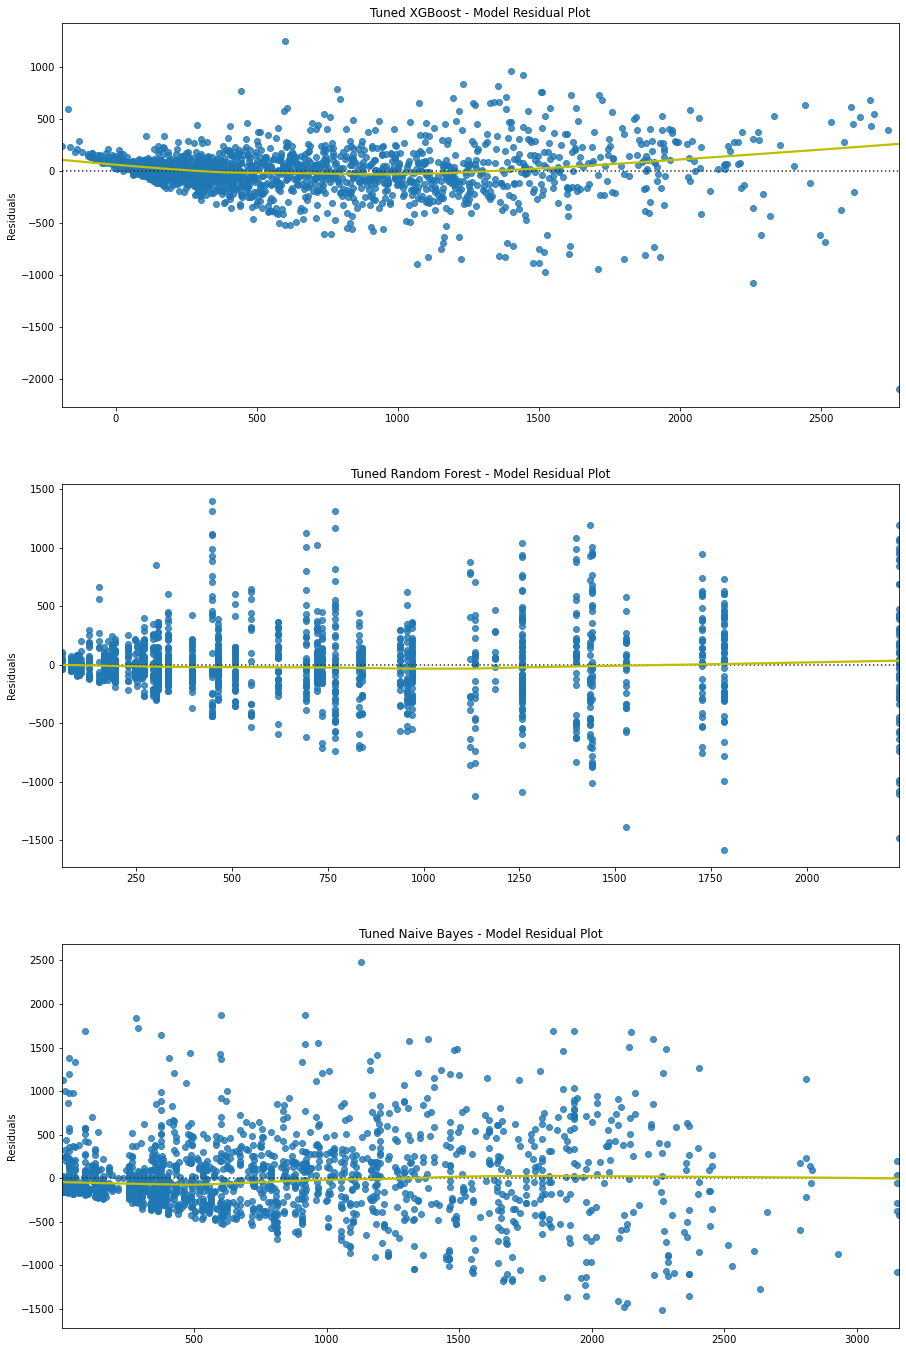

In [46]:
def make_residual_plot():

    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 24))

    for idx, model_info in enumerate([('Tuned XGBoost', xgb_tuned), ('Tuned Random Forest', rf_tuned), ('Tuned Naive Bayes', nb_tuned)]):

        model_name = model_info[0]
        model = model_info[1]

        sns.residplot(
            ax = ax[idx],
            x = model.predict(X_val),
            y = y_val,
            lowess = True,
            line_kws = {'color' : 'y'},
        ).set(title = f'{model_name} - Model Residual Plot', ylabel = 'Residuals')

    plt.savefig(p.OUTPUTS_PATH + 'residuals1.png')
    plt.show()

make_residual_plot()

As we can from the residual plots above, the Tuned XGBoost model has residuals closest to the y = 0 line. It looks like the residuals are larger at the extremities.... unexplained variance.

### Save the best model

In [ ]:
f.save_model_and_preds(xgb_tuned, model_name = 'best', X = X_val)